This presentation outlines the development of two Machine Learning models: one for predicting the lifespan of metal parts based on processing parameters and another for automatically classifying parts as defective or non-defective using image scans. The models, trained on cleaned data provided by the manufacturing company, offer potential solutions to refine the production process and streamline quality control.


In [1]:
#Import all datasets being used
import numpy as np # A useful package for dealing with mathematical processes, we will be using it this week for vectors and matrices
import pandas as pd # A common package for viewing tabular data
import seaborn as sns
import sklearn.linear_model, sklearn.datasets # We want to be able to access the sklearn datasets again, also we are using some model evaluation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder # We will be using the inbuilt preprocessing functions sklearn provides
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs
from sklearn.model_selection import train_test_split # A library that can automatically perform data splitting for us
from sklearn.linear_model import Ridge, Lasso, LinearRegression # Ridge & Lasso regression are types of linear model that use regularisation
from sklearn.metrics import mean_squared_error, r2_score # Allows us to use the MSE function without calling in sklearn each time
from google.colab import files # We will be importing a csv file I have provided for one section.
import warnings
warnings.filterwarnings('ignore') # suppresses a convergence warning we may get when testing Lasso - this is just cosmetic to stop too much output.

# **Part 2 - Executive Summary**

### **Viewing and selecting data**

In [2]:
dataset1 = pd.read_csv("/content/dataset1.csv")

In [3]:
dataset1

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,284.161690,Blade,colGrain,25,4.460592,7.937116,22,0,7,Top,Investment
1,1599.551748,Blade,singleGrain,9,1.425973,2.432948,2,0,0,Bottom,Die
2,768.311031,Nozzle,colGrain,26,2.508879,3.841211,25,0,0,Bottom,Investment
3,1697.663828,Blade,colGrain,12,3.248913,2.610700,10,0,0,Bottom,Continuous
4,1491.478862,Nozzle,colGrain,20,1.901670,4.634926,24,0,0,Top,Die
...,...,...,...,...,...,...,...,...,...,...,...
995,462.984817,Blade,equiGrain,24,2.023624,2.741713,20,0,0,Bottom,Continuous
996,1426.298870,Nozzle,equiGrain,21,1.741670,7.206022,12,0,0,Bottom,Investment
997,1538.072772,Blade,colGrain,14,1.658847,8.276388,12,0,0,Top,Investment
998,1893.052813,Nozzle,equiGrain,9,2.124314,5.033330,0,0,0,Bottom,Continuous


In [4]:
dataset1.shape

(1000, 11)

In [5]:
dataset1.dtypes

Lifespan          float64
partType           object
microstructure     object
coolingRate         int64
quenchTime        float64
forgeTime         float64
smallDefects        int64
largeDefects        int64
sliverDefects       int64
seedLocation       object
castType           object
dtype: object

In [6]:
dataset1.describe()

,Lifespan,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,1366.373468,17.480000,2.786059,5.497136,13.37100,0.117000,0.286000
std,519.026551,7.557958,1.320935,2.613501,8.07047,0.565359,1.351307
min,115.120563,5.000000,0.501046,1.017799,0.00000,0.000000,0.000000
25%,960.976320,11.000000,1.608916,3.203739,8.00000,0.000000,0.000000
50%,1470.377014,17.000000,2.824488,5.510765,16.00000,0.000000,0.000000
75%,1757.165684,24.000000,3.902389,7.735951,20.00000,0.000000,0.000000
max,2380.142759,30.000000,4.990795,9.988511,33.00000,4.000000,10.000000


In [7]:
dataset1.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,284.161690,Blade,colGrain,25,4.460592,7.937116,22,0,7,Top,Investment
1,1599.551748,Blade,singleGrain,9,1.425973,2.432948,2,0,0,Bottom,Die
2,768.311031,Nozzle,colGrain,26,2.508879,3.841211,25,0,0,Bottom,Investment
3,1697.663828,Blade,colGrain,12,3.248913,2.610700,10,0,0,Bottom,Continuous
4,1491.478862,Nozzle,colGrain,20,1.901670,4.634926,24,0,0,Top,Die


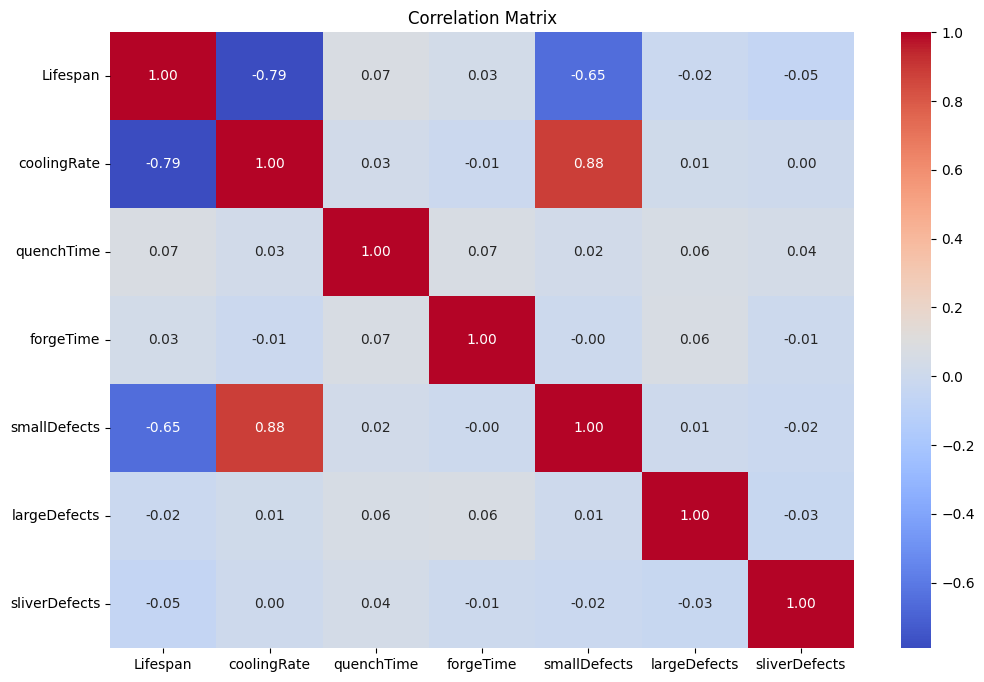

In [8]:
# Explore correlations using a heatmap for numerical features
correlation_matrix = dataset1.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


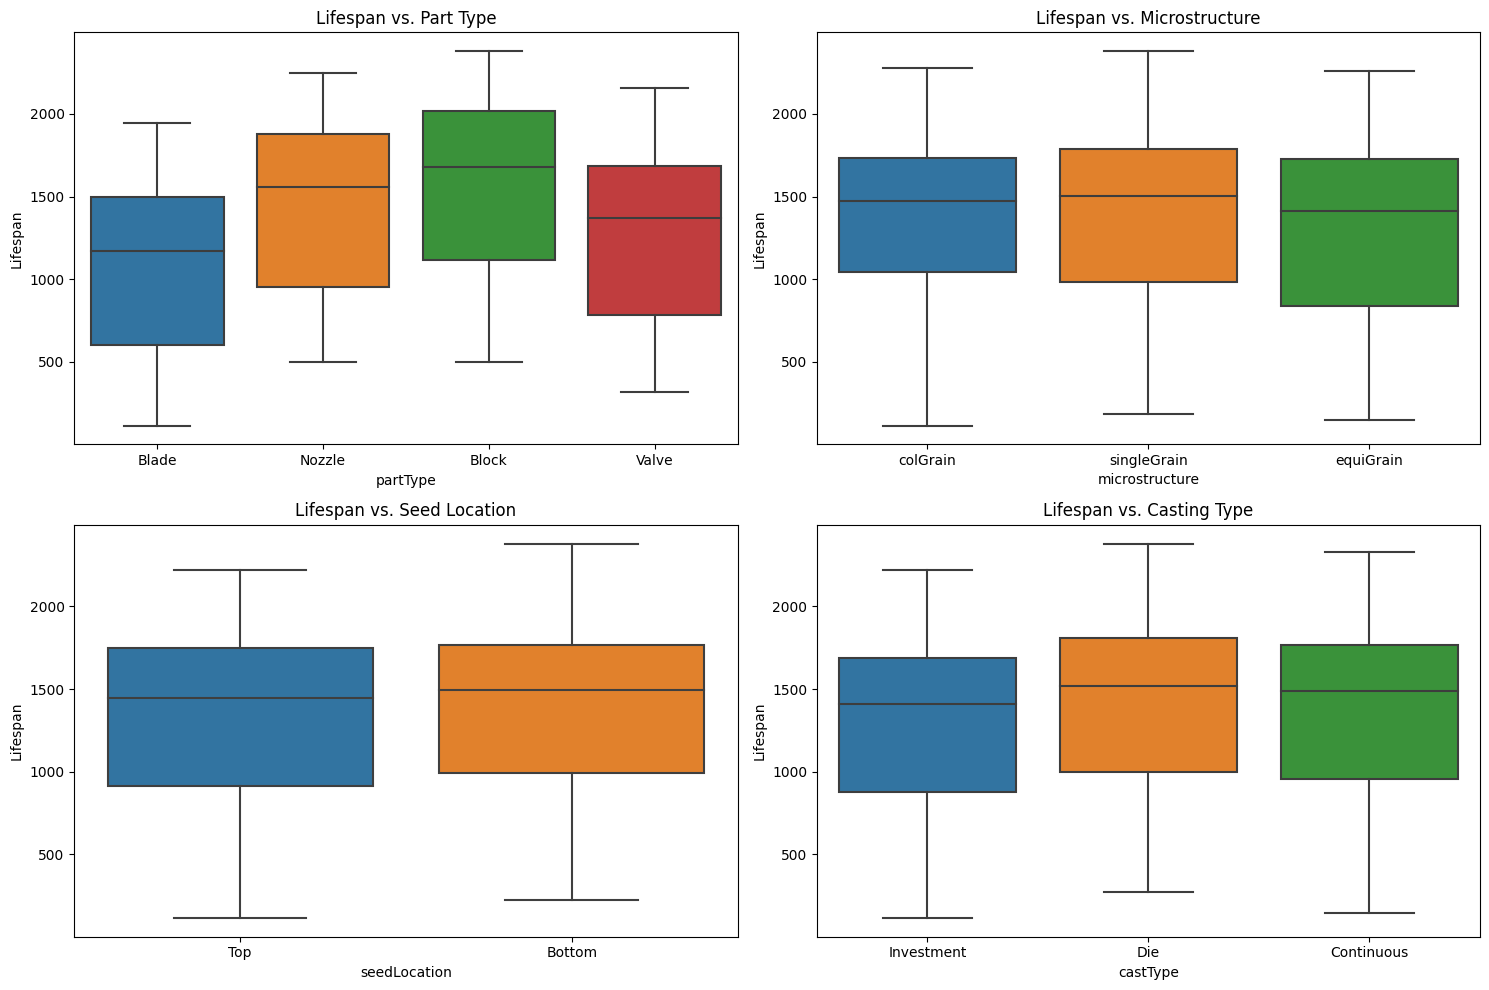

In [9]:
# Explore relationships with box plots
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='partType', y='Lifespan', data=dataset1)
plt.title('Lifespan vs. Part Type')

plt.subplot(2, 2, 2)
sns.boxplot(x='microstructure', y='Lifespan', data=dataset1)
plt.title('Lifespan vs. Microstructure')

plt.subplot(2, 2, 3)
sns.boxplot(x='seedLocation', y='Lifespan', data=dataset1)
plt.title('Lifespan vs. Seed Location')

plt.subplot(2, 2, 4)
sns.boxplot(x='castType', y='Lifespan', data=dataset1)
plt.title('Lifespan vs. Casting Type')

plt.tight_layout()
plt.show()

# **Part 3 - Regression Implementation**

In [10]:
rng = np.random.default_rng(0)
dataset1 = dataset1.iloc[rng.permutation(len(dataset1))].reset_index(drop=True)

In [11]:
dataset1.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,1666.725196,Valve,singleGrain,8,1.926442,7.734983,0,0,0,Bottom,Investment
1,748.692186,Nozzle,equiGrain,27,1.208072,5.055080,23,0,0,Top,Die
2,921.860980,Blade,equiGrain,23,1.546579,5.184329,18,0,0,Top,Investment
3,711.171067,Valve,colGrain,25,4.279373,1.464497,21,0,0,Bottom,Die
4,1419.362159,Nozzle,equiGrain,21,0.764169,1.070946,19,0,0,Bottom,Die


In [12]:
# Create feature Matrix
X = dataset1.drop("Lifespan", axis=1)

# Create label
y = dataset1["Lifespan"]

In [13]:
X

,partType,microstructure,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,Valve,singleGrain,8,1.926442,7.734983,0,0,0,Bottom,Investment
1,Nozzle,equiGrain,27,1.208072,5.055080,23,0,0,Top,Die
2,Blade,equiGrain,23,1.546579,5.184329,18,0,0,Top,Investment
3,Valve,colGrain,25,4.279373,1.464497,21,0,0,Bottom,Die
4,Nozzle,equiGrain,21,0.764169,1.070946,19,0,0,Bottom,Die
...,...,...,...,...,...,...,...,...,...,...
995,Nozzle,singleGrain,24,3.390229,9.586600,25,0,0,Bottom,Die
996,Nozzle,singleGrain,9,2.555044,3.100129,0,0,0,Top,Continuous
997,Block,colGrain,8,4.514887,5.630995,0,0,6,Top,Die
998,Valve,colGrain,24,2.525641,5.101369,21,0,0,Top,Continuous


In [14]:
y

0      1666.725196
1       748.692186
2       921.860980
3       711.171067
4      1419.362159
          ...     
995    1060.484406
996    1924.690556
997    1973.520438
998     696.977263
999     476.817221
Name: Lifespan, Length: 1000, dtype: float64

## **Converting categorical data to numerical**

In [15]:
X.head()

,partType,microstructure,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,Valve,singleGrain,8,1.926442,7.734983,0,0,0,Bottom,Investment
1,Nozzle,equiGrain,27,1.208072,5.055080,23,0,0,Top,Die
2,Blade,equiGrain,23,1.546579,5.184329,18,0,0,Top,Investment
3,Valve,colGrain,25,4.279373,1.464497,21,0,0,Bottom,Die
4,Nozzle,equiGrain,21,0.764169,1.070946,19,0,0,Bottom,Die


In [16]:
X["partType"].value_counts()

Nozzle    293
Valve     241
Blade     236
Block     230
Name: partType, dtype: int64

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ["partType", "microstructure", "seedLocation", "castType"]
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder='passthrough')

transformed_X = transformer.fit_transform(X)
transformed_X

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ..., 23.,  0.,  0.],
       [ 1.,  0.,  0., ..., 18.,  0.,  0.],
       ...,
       [ 0.,  1.,  0., ...,  0.,  0.,  6.],
       [ 0.,  0.,  0., ..., 21.,  0.,  0.],
       [ 1.,  0.,  0., ..., 22.,  0.,  0.]])

In [18]:
transformed_X = pd.DataFrame(transformed_X)
transformed_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,8.0,1.926442,7.734983,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,27.0,1.208072,5.055080,23.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,23.0,1.546579,5.184329,18.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,25.0,4.279373,1.464497,21.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,21.0,0.764169,1.070946,19.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,24.0,3.390229,9.586600,25.0,0.0,0.0
996,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,9.0,2.555044,3.100129,0.0,0.0,0.0
997,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.0,4.514887,5.630995,0.0,0.0,6.0
998,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,24.0,2.525641,5.101369,21.0,0.0,0.0


## **Splitting data into training and test sets**

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 18), (200, 18), (800,), (200,))

In [21]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
670,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,30.0,2.987279,3.574697,17.0,0.0,0.0
621,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,18.0,2.727962,5.019597,18.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,25.0,4.279373,1.464497,21.0,0.0,0.0
559,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,25.0,3.705756,4.387059,21.0,0.0,0.0
836,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,22.0,1.260886,8.335495,18.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,25.0,3.229425,3.569043,23.0,0.0,0.0
155,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,15.0,4.914759,6.702142,10.0,0.0,0.0
185,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,27.0,3.973070,9.024994,14.0,0.0,0.0
895,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,24.0,2.023624,2.741713,20.0,0.0,0.0


## **Trying out various regression models**


### Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

model = LinearRegression(fit_intercept=True)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

r2 = r2_score(y_test, y_preds)
print(r2)

mae = mean_absolute_error(y_test, y_preds)
print(mae)

mse = mean_squared_error(y_test, y_preds)
print(np.sqrt(mse))

0.773456513541212
190.7164422672312
232.0492509410747


### Support Vector Machines

In [23]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

model = SVR(kernel='linear')

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

r2 = r2_score(y_test, y_preds)
print(r2)

mae = mean_absolute_error(y_test, y_preds)
print(mae)

mse = mean_squared_error(y_test, y_preds)
print(np.sqrt(mse))


0.7087971810827486
211.22136842085115
263.0886838113463


### Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

model = RandomForestRegressor(n_estimators=100)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

r2 = r2_score(y_test, y_preds)
print(r2)

mae = mean_absolute_error(y_test, y_preds)
print(mae)

mse = mean_squared_error(y_test, y_preds)
print(np.sqrt(mse))

0.9725987110228747
64.15744434361581
80.70303681254362


### Decision Tree Regressor

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

model = DecisionTreeRegressor()

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

r2 = r2_score(y_test, y_preds)
print(r2)

mae = mean_absolute_error(y_test, y_preds)
print(mae)

mse = mean_squared_error(y_test, y_preds)
print(np.sqrt(mse))

0.9571196206941593
79.57269445741896
100.95636149493049


## **Feature Scaling**

In [26]:
X.head()

,partType,microstructure,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,Valve,singleGrain,8,1.926442,7.734983,0,0,0,Bottom,Investment
1,Nozzle,equiGrain,27,1.208072,5.055080,23,0,0,Top,Die
2,Blade,equiGrain,23,1.546579,5.184329,18,0,0,Top,Investment
3,Valve,colGrain,25,4.279373,1.464497,21,0,0,Bottom,Die
4,Nozzle,equiGrain,21,0.764169,1.070946,19,0,0,Bottom,Die


In [27]:
num_features = ["coolingRate", "quenchTime", "forgeTime", "smallDefects","largeDefects","sliverDefects"]
cat_features = ["partType", "microstructure", "seedLocation", "castType"]

In [28]:
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

transformer = ColumnTransformer([
    # ('min_max_scaler', MinMaxScaler(), num_features),
    ('std_scaler', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
])

X_prepared = transformer.fit_transform(X)

In [29]:
X_prepared

array([[-1.25493474, -0.65109024,  0.85669231, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.26022983, -1.19519668, -0.16922801, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.7307215 , -0.93880528, -0.11974893, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-1.25493474,  1.30944562,  0.05124373, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.86309858, -0.19724554, -0.15150772, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.26022983,  0.20338142, -0.36075747, ...,  0.        ,
         1.        ,  0.        ]])

In [30]:
X_prepared = pd.DataFrame(X_prepared)

In [31]:
## Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2)

### **Trying out models**

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_preds = lin_reg.predict(X_test)

# r2 = r2_score(y_test, y_preds)
# print(r2)

# mae = mean_absolute_error(y_test, y_preds)
# print(mae)

mse = mean_squared_error(y_test, y_preds)
print(np.sqrt(mse))

233.90869199366838


### Support Vector Regressor

In [34]:
from sklearn.svm import SVR

model = SVR(kernel='linear')

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

# r2 = r2_score(y_test, y_preds)
# print(r2)

# mae = mean_absolute_error(y_test, y_preds)
# print(mae)

mse = mean_squared_error(y_test, y_preds)
print(np.sqrt(mse))

302.9267154663619


### Random Forest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

# r2 = r2_score(y_test, y_preds)
# print(r2)

# mae = mean_absolute_error(y_test, y_preds)
# print(mae)

mse = mean_squared_error(y_test, y_preds)
print(np.sqrt(mse))

73.97549427981069


### Decision Tree Regressor

In [36]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

# r2 = r2_score(y_test, y_preds)
# print(r2)

# mae = mean_absolute_error(y_test, y_preds)
# print(mae)

mse = mean_squared_error(y_test, y_preds)
print(np.sqrt(mse))

109.60020728653677


## **Using Cross Validation**

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
transformer = ColumnTransformer([
    # ('min_max_scaler', MinMaxScaler(), num_features),
    ('std_scaler', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
])

X_prepared = transformer.fit_transform(X)

In [38]:
X_prepared = pd.DataFrame(X_prepared)

## **Trying out models**

### Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

In [40]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

In [41]:
print("Scores: ", lin_rmse_scores)
print("Mean: ", lin_rmse_scores.mean())
print("Standard Deviation: ", lin_rmse_scores.std())

Scores:  [252.08919342 230.20451392 245.98442802 204.15810078 227.79499342
 233.40043314 228.4275402  218.89386313 241.15378315 268.38342239]
Mean:  235.04902715579047
Standard Deviation:  17.01849327194365


### Support Vector Machine

In [42]:
from sklearn.svm import SVR

svr = SVR(kernel='linear')

In [43]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svr, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-scores)

In [44]:
print("Scores: ", svr_rmse_scores)
print("Mean: ", svr_rmse_scores.mean())
print("Standard Deviation: ", svr_rmse_scores.std())

Scores:  [315.64835234 292.60686165 327.41075881 274.06383009 259.54498371
 329.19182361 317.9093889  303.19333997 315.88787171 328.64026451]
Mean:  306.4097475303048
Standard Deviation:  22.8147302388679


### Random Forest Regressor

In [45]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100)

In [46]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfr, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
rfr_rmse_scores = np.sqrt(-scores)

In [47]:
print("Scores: ", rfr_rmse_scores)
print("Mean: ", rfr_rmse_scores.mean())
print("Standard Deviation: ", rfr_rmse_scores.std())

Scores:  [80.68470258 78.77342179 67.30282289 71.15294921 69.54984953 65.94842874
 61.49600651 71.04744458 77.25770036 81.51172263]
Mean:  72.47250488148799
Standard Deviation:  6.432992572614422


### Decision Tree Regressor

In [48]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

In [49]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [50]:
print("Scores: ", tree_rmse_scores)
print("Mean: ", tree_rmse_scores.mean())
print("Standard Deviation: ", tree_rmse_scores.std())

Scores:  [106.41726135 109.18312182 102.05281076 105.06192988  99.60904228
  96.36549388 110.33619218 107.64608433 128.48626955 109.52469934]
Mean:  107.46829053716911
Standard Deviation:  8.236770652919281


## GridSearchCV

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV



# Create a Random Forest Regressor
regressor = RandomForestRegressor()

# Define the hyperparameters you want to tune
param_grid = [ {'n_estimators': [3, 10, 25, 50], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [6, 8], 'max_features': [2, 3, 4]}, ]

# Create the GridSearchCV object
grid_search = GridSearchCV(regressor, param_grid, cv=5, n_jobs=-1, verbose=2)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Get the best estimator
best_regressor = grid_search.best_estimator_

# Evaluate the model on the test set
test_predictions = best_regressor.predict(X_test)

# You can now use 'best_regressor' for making predictions on new data.


Fitting 5 folds for each of 22 candidates, totalling 110 fits
Best hyperparameters found:
{'max_features': 8, 'n_estimators': 50}


In [52]:
# r2 = r2_score(y_test, y_preds)
# print(r2)

# mae = mean_absolute_error(y_test, y_preds)
# print(mae)

mse = mean_squared_error(y_test, y_preds)
print(np.sqrt(mse))

109.60020728653677


# **Part 4 - Binary Classification Implementation**

In [53]:
dataset1 = pd.read_csv("/content/dataset1.csv")

In [54]:
dataset1

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,284.161690,Blade,colGrain,25,4.460592,7.937116,22,0,7,Top,Investment
1,1599.551748,Blade,singleGrain,9,1.425973,2.432948,2,0,0,Bottom,Die
2,768.311031,Nozzle,colGrain,26,2.508879,3.841211,25,0,0,Bottom,Investment
3,1697.663828,Blade,colGrain,12,3.248913,2.610700,10,0,0,Bottom,Continuous
4,1491.478862,Nozzle,colGrain,20,1.901670,4.634926,24,0,0,Top,Die
...,...,...,...,...,...,...,...,...,...,...,...
995,462.984817,Blade,equiGrain,24,2.023624,2.741713,20,0,0,Bottom,Continuous
996,1426.298870,Nozzle,equiGrain,21,1.741670,7.206022,12,0,0,Bottom,Investment
997,1538.072772,Blade,colGrain,14,1.658847,8.276388,12,0,0,Top,Investment
998,1893.052813,Nozzle,equiGrain,9,2.124314,5.033330,0,0,0,Bottom,Continuous


In [55]:
dataset1.shape

(1000, 11)

In [56]:
dataset1.dtypes

Lifespan          float64
partType           object
microstructure     object
coolingRate         int64
quenchTime        float64
forgeTime         float64
smallDefects        int64
largeDefects        int64
sliverDefects       int64
seedLocation       object
castType           object
dtype: object

In [57]:
rng = np.random.default_rng(0)
dataset1 = dataset1.iloc[rng.permutation(len(dataset1))].reset_index(drop=True)

In [58]:
dataset1.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,1666.725196,Valve,singleGrain,8,1.926442,7.734983,0,0,0,Bottom,Investment
1,748.692186,Nozzle,equiGrain,27,1.208072,5.055080,23,0,0,Top,Die
2,921.860980,Blade,equiGrain,23,1.546579,5.184329,18,0,0,Top,Investment
3,711.171067,Valve,colGrain,25,4.279373,1.464497,21,0,0,Bottom,Die
4,1419.362159,Nozzle,equiGrain,21,0.764169,1.070946,19,0,0,Bottom,Die


In [59]:
dataset1["target"] = dataset1["Lifespan"].apply(lambda x: 1 if x >= 1500 else 0)

In [60]:
dataset1

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects,seedLocation,castType,target
0,1666.725196,Valve,singleGrain,8,1.926442,7.734983,0,0,0,Bottom,Investment,1
1,748.692186,Nozzle,equiGrain,27,1.208072,5.055080,23,0,0,Top,Die,0
2,921.860980,Blade,equiGrain,23,1.546579,5.184329,18,0,0,Top,Investment,0
3,711.171067,Valve,colGrain,25,4.279373,1.464497,21,0,0,Bottom,Die,0
4,1419.362159,Nozzle,equiGrain,21,0.764169,1.070946,19,0,0,Bottom,Die,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1060.484406,Nozzle,singleGrain,24,3.390229,9.586600,25,0,0,Bottom,Die,0
996,1924.690556,Nozzle,singleGrain,9,2.555044,3.100129,0,0,0,Top,Continuous,1
997,1973.520438,Block,colGrain,8,4.514887,5.630995,0,0,6,Top,Die,1
998,696.977263,Valve,colGrain,24,2.525641,5.101369,21,0,0,Top,Continuous,0


In [61]:
dataset1.drop(["Lifespan"], axis=1, inplace=True)

In [62]:
dataset1.head()

,partType,microstructure,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects,seedLocation,castType,target
0,Valve,singleGrain,8,1.926442,7.734983,0,0,0,Bottom,Investment,1
1,Nozzle,equiGrain,27,1.208072,5.055080,23,0,0,Top,Die,0
2,Blade,equiGrain,23,1.546579,5.184329,18,0,0,Top,Investment,0
3,Valve,colGrain,25,4.279373,1.464497,21,0,0,Bottom,Die,0
4,Nozzle,equiGrain,21,0.764169,1.070946,19,0,0,Bottom,Die,0


In [63]:
dataset1['target'].value_counts()

0    529
1    471
Name: target, dtype: int64

In [64]:
# Create feature Matrix
X = dataset1.drop("target", axis=1)

# Create label
y = dataset1["target"]

In [65]:
X.head()

,partType,microstructure,coolingRate,quenchTime,forgeTime,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,Valve,singleGrain,8,1.926442,7.734983,0,0,0,Bottom,Investment
1,Nozzle,equiGrain,27,1.208072,5.055080,23,0,0,Top,Die
2,Blade,equiGrain,23,1.546579,5.184329,18,0,0,Top,Investment
3,Valve,colGrain,25,4.279373,1.464497,21,0,0,Bottom,Die
4,Nozzle,equiGrain,21,0.764169,1.070946,19,0,0,Bottom,Die


In [66]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [67]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ["partType", "microstructure", "seedLocation", "castType"]
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder='passthrough')

transformed_X = transformer.fit_transform(X)
transformed_X

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ..., 23.,  0.,  0.],
       [ 1.,  0.,  0., ..., 18.,  0.,  0.],
       ...,
       [ 0.,  1.,  0., ...,  0.,  0.,  6.],
       [ 0.,  0.,  0., ..., 21.,  0.,  0.],
       [ 1.,  0.,  0., ..., 22.,  0.,  0.]])

In [68]:
transformed_X = pd.DataFrame(transformed_X)
transformed_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,8.0,1.926442,7.734983,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,27.0,1.208072,5.055080,23.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,23.0,1.546579,5.184329,18.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,25.0,4.279373,1.464497,21.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,21.0,0.764169,1.070946,19.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,24.0,3.390229,9.586600,25.0,0.0,0.0
996,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,9.0,2.555044,3.100129,0.0,0.0,0.0
997,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.0,4.514887,5.630995,0.0,0.0,6.0
998,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,24.0,2.525641,5.101369,21.0,0.0,0.0


## **Splitting data into training and test sets**

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2)

In [70]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 18), (200, 18), (800,), (200,))

In [71]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
347,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,26.0,2.744458,9.053462,20.0,0.0,0.0
25,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,18.0,4.429384,1.687756,19.0,0.0,0.0
275,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,30.0,2.460635,3.411295,18.0,0.0,0.0
298,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,4.950361,4.069703,22.0,0.0,0.0
295,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,20.0,3.999945,3.195821,16.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,25.0,3.229425,3.569043,23.0,0.0,0.0
669,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,22.0,1.569800,9.263526,19.0,0.0,0.0
884,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,28.0,1.262104,3.775352,23.0,0.0,0.0
169,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,15.0,2.484700,8.263649,10.0,0.0,0.0


## **Trying out various Classification models**


In [72]:
model_scores = {}

## Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train, y_train)

model_scores["Logistic Regression"] = model.score(X_test, y_test)

## SVM

In [74]:
from sklearn.svm import SVC

model = SVC(C=1,kernel='rbf',random_state=40)

model.fit(X_train, y_train)

model_scores["SVM"] = model.score(X_test, y_test)

## Decision Tree Classifier

In [75]:
from sklearn.tree import DecisionTreeClassifier


model = DecisionTreeClassifier(random_state=0)

model.fit(X_train, y_train)

model_scores["Decision Tree"] = model.score(X_test, y_test)

## Random Forest Regressor

In [76]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)

model.fit(X_train, y_train)

model_scores["Random Forest"] = model.score(X_test, y_test)

In [77]:
model_scores

{'Logistic Regression': 0.815,
 'SVM': 0.855,
 'Decision Tree': 0.92,
 'Random Forest': 0.93}

<Axes: >

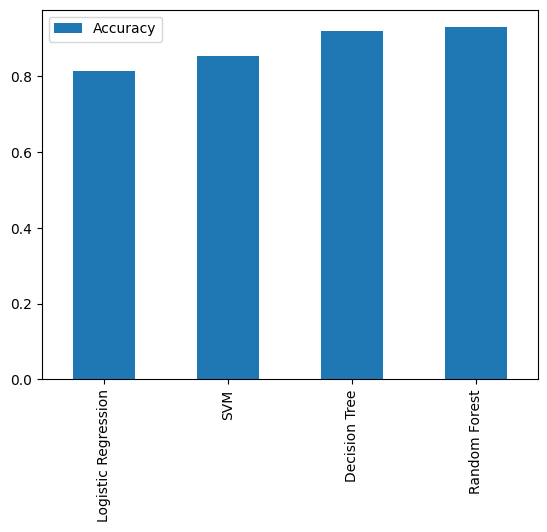

In [78]:
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
model_compare.T.plot.bar()

## Feature Scaling

In [79]:
num_features = ["coolingRate", "quenchTime", "forgeTime", "smallDefects","largeDefects","sliverDefects"]
cat_features = ["partType", "microstructure", "seedLocation", "castType"]

In [80]:
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

transformer = ColumnTransformer([
    # ('min_max_scaler', MinMaxScaler(), num_features),
    ('std_scaler', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
])

X_prepared = transformer.fit_transform(X)

In [81]:
X_prepared

array([[-1.25493474, -0.65109024,  0.85669231, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.26022983, -1.19519668, -0.16922801, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.7307215 , -0.93880528, -0.11974893, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-1.25493474,  1.30944562,  0.05124373, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.86309858, -0.19724554, -0.15150772, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.26022983,  0.20338142, -0.36075747, ...,  0.        ,
         1.        ,  0.        ]])

In [82]:
X_prepared = pd.DataFrame(X_prepared)
X_prepared

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.254935,-0.651090,0.856692,-1.657610,-0.207052,-0.211753,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1.260230,-1.195197,-0.169228,1.193712,-0.207052,-0.211753,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.730721,-0.938805,-0.119749,0.573860,-0.207052,-0.211753,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.995476,1.131063,-1.543775,0.945771,-0.207052,-0.211753,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.465967,-1.531417,-1.694434,0.697830,-0.207052,-0.211753,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.863099,0.457609,1.565528,1.441653,-0.207052,-0.211753,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
996,-1.122558,-0.174976,-0.917622,-1.657610,-0.207052,-0.211753,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
997,-1.254935,1.309446,0.051244,-1.657610,-0.207052,4.230615,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
998,0.863099,-0.197246,-0.151508,0.945771,-0.207052,-0.211753,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [83]:
## Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2)

## **Trying out models**

In [84]:
from sklearn.metrics import classification_report

## Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train, y_train)

y_preds = lr.predict(X_test)

print(classification_report(y_test, y_preds))


              precision    recall  f1-score   support

           0       0.89      0.78      0.83       109
           1       0.77      0.88      0.82        91

    accuracy                           0.82       200
   macro avg       0.83      0.83      0.82       200
weighted avg       0.83      0.82      0.83       200



In [86]:
from sklearn.metrics import roc_curve

y_probs = lr.predict_proba(X_test)
y_probs_pos = y_probs[:, 1]
y_probs_pos[:10]

array([0.44231248, 0.85694503, 0.71152824, 0.49736623, 0.94889535,
       0.67493525, 0.99446612, 0.25685785, 0.97864293, 0.80258198])

In [87]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs_pos)

fpr

array([0.        , 0.        , 0.        , 0.00917431, 0.00917431,
       0.01834862, 0.01834862, 0.02752294, 0.02752294, 0.03669725,
       0.03669725, 0.04587156, 0.04587156, 0.05504587, 0.05504587,
       0.06422018, 0.06422018, 0.08256881, 0.08256881, 0.11926606,
       0.11926606, 0.13761468, 0.13761468, 0.14678899, 0.14678899,
       0.19266055, 0.19266055, 0.20183486, 0.20183486, 0.21100917,
       0.21100917, 0.25688073, 0.25688073, 0.26605505, 0.26605505,
       0.29357798, 0.29357798, 0.32110092, 0.32110092, 0.35779817,
       0.35779817, 0.42201835, 0.42201835, 0.47706422, 0.47706422,
       0.55045872, 0.55045872, 0.63302752, 0.63302752, 1.        ])

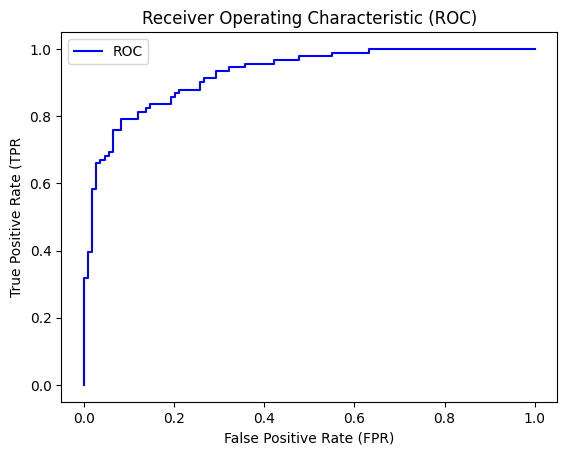

In [88]:
plt.plot(fpr, tpr, color="blue", label="ROC")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_probs_pos)

0.9253957052122189

## SVM

In [90]:
from sklearn.svm import SVC

svm = SVC(C=1,kernel='rbf',random_state=40, probability=True)

svm.fit(X_train, y_train)

y_preds = svm.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       109
           1       0.84      0.89      0.87        91

    accuracy                           0.88       200
   macro avg       0.87      0.88      0.87       200
weighted avg       0.88      0.88      0.88       200



In [91]:
from sklearn.metrics import roc_curve

y_probs = svm.predict_proba(X_test)
y_probs_pos = y_probs[:, 1]
y_probs_pos[:10]

array([0.12656237, 0.93008306, 0.85021121, 0.58928976, 0.98526922,
       0.92561673, 0.98045796, 0.18058219, 0.999998  , 0.98274666])

In [92]:
sfpr, stpr, thresholds = roc_curve(y_test, y_probs_pos)

sfpr

array([0.        , 0.        , 0.        , 0.01834862, 0.01834862,
       0.03669725, 0.03669725, 0.04587156, 0.04587156, 0.06422018,
       0.06422018, 0.0733945 , 0.0733945 , 0.09174312, 0.09174312,
       0.11926606, 0.11926606, 0.13761468, 0.13761468, 0.1559633 ,
       0.1559633 , 0.16513761, 0.16513761, 0.18348624, 0.18348624,
       0.19266055, 0.19266055, 0.20183486, 0.20183486, 0.27522936,
       0.27522936, 0.30275229, 0.30275229, 1.        ])

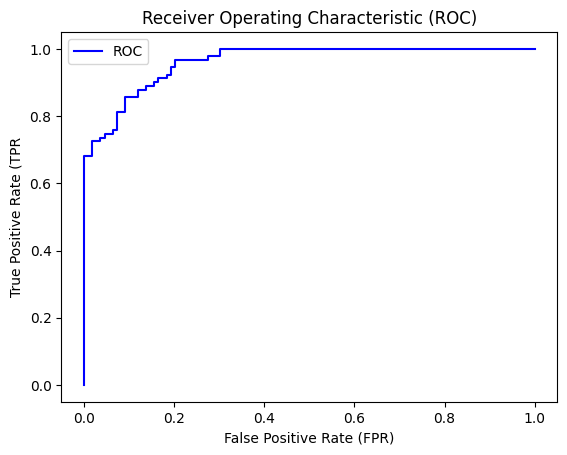

In [93]:
plt.plot(sfpr, stpr, color="blue", label="ROC")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()

In [94]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_probs_pos)

0.9614880532311726

## Decision Tree Classifier

In [95]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)

tree.fit(X_train, y_train)

y_preds = tree.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       109
           1       0.87      0.95      0.91        91

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



In [96]:
from sklearn.metrics import roc_curve

y_probs = tree.predict_proba(X_test)
y_probs_pos = y_probs[:, 1]
y_probs_pos[:10]

array([0., 1., 0., 0., 1., 1., 1., 0., 1., 1.])

In [97]:
tfpr, ttpr, thresholds = roc_curve(y_test, y_probs_pos)

tfpr

array([0.        , 0.11926606, 1.        ])

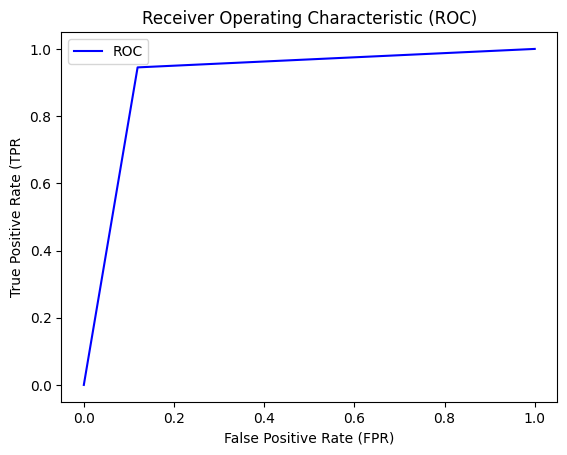

In [98]:
plt.plot(tfpr, ttpr, color="blue", label="ROC")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()

In [99]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_probs_pos)

0.9128944450045368

## Random Forest Regressor

In [100]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)

rfc.fit(X_train, y_train)

y_preds = rfc.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       109
           1       0.86      0.96      0.91        91

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



In [101]:
from sklearn.metrics import precision_score

precision = precision_score(y_test, y_preds)
print("Precision Score:", precision)


Precision Score: 0.8613861386138614


In [102]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, y_preds)
print("Recall Score:", recall)


Recall Score: 0.9560439560439561


In [103]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)


F1 Score: 0.90625


In [104]:
from sklearn.metrics import roc_curve

y_probs = rfc.predict_proba(X_test)
y_probs_pos = y_probs[:, 1]
y_probs_pos[:10]

array([0.1 , 0.81, 0.58, 0.29, 0.9 , 0.53, 0.97, 0.22, 0.99, 0.98])

In [105]:
rfpr, rtpr, thresholds = roc_curve(y_test, y_probs_pos)

fpr

array([0.        , 0.        , 0.        , 0.00917431, 0.00917431,
       0.01834862, 0.01834862, 0.02752294, 0.02752294, 0.03669725,
       0.03669725, 0.04587156, 0.04587156, 0.05504587, 0.05504587,
       0.06422018, 0.06422018, 0.08256881, 0.08256881, 0.11926606,
       0.11926606, 0.13761468, 0.13761468, 0.14678899, 0.14678899,
       0.19266055, 0.19266055, 0.20183486, 0.20183486, 0.21100917,
       0.21100917, 0.25688073, 0.25688073, 0.26605505, 0.26605505,
       0.29357798, 0.29357798, 0.32110092, 0.32110092, 0.35779817,
       0.35779817, 0.42201835, 0.42201835, 0.47706422, 0.47706422,
       0.55045872, 0.55045872, 0.63302752, 0.63302752, 1.        ])

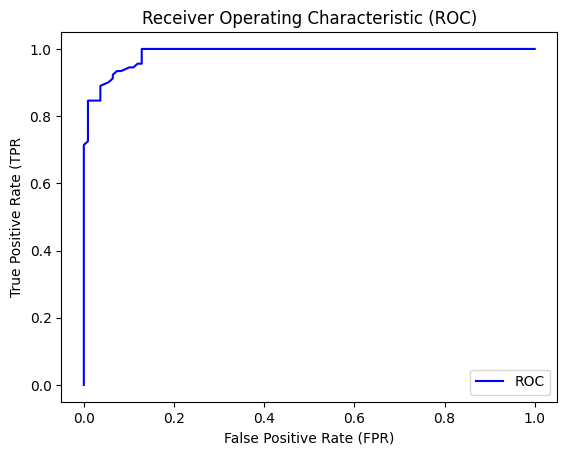

In [106]:
plt.plot(rfpr, rtpr, color="blue", label="ROC")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()

In [107]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_probs_pos)

0.9866922068756931

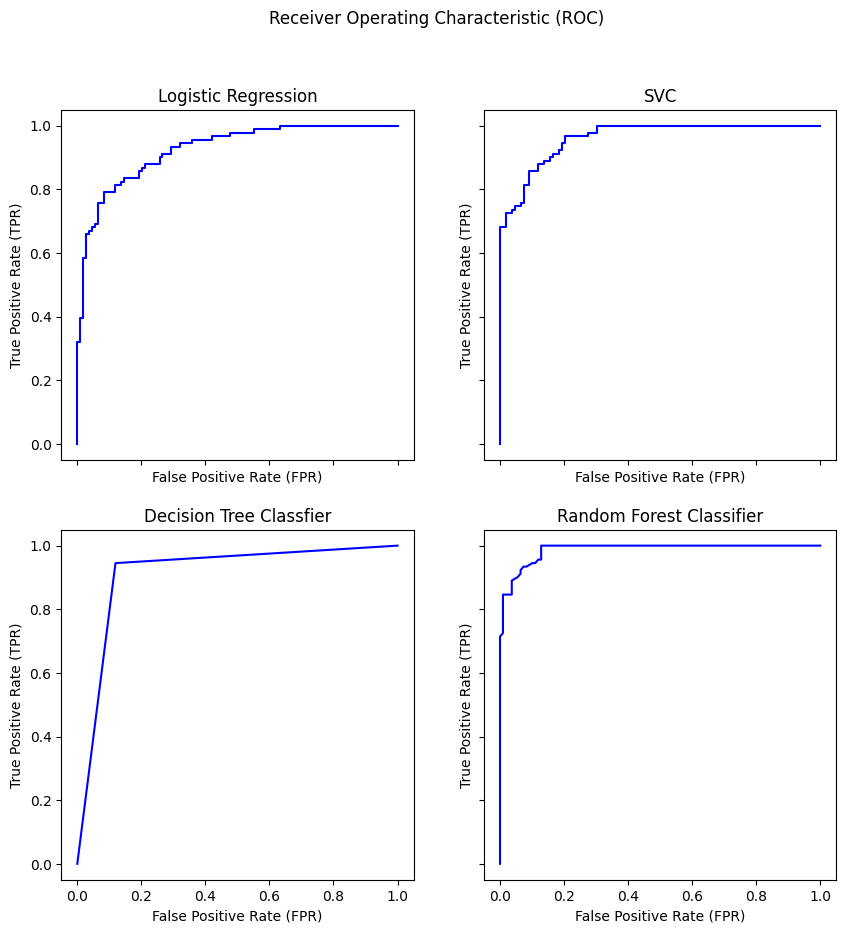

In [108]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.set
fig.suptitle("Receiver Operating Characteristic (ROC)")
ax1.plot(fpr, tpr, color="blue", label="ROC")
ax1.set_title("Logistic Regression")
ax2.plot(sfpr, stpr, color="blue", label="ROC")
ax2.set_title("SVC")
ax3.plot(tfpr, ttpr, color="blue", label="ROC")
ax3.set_title("Decision Tree Classfier")
ax4.plot(rfpr, rtpr, color="blue", label="ROC")
ax4.set_title("Random Forest Classifier")

for ax in fig.get_axes():
    ax.label_outer()

for ax in fig.get_axes():
  ax.set(xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR)')

## **Cross Validation**

In [109]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfc, X_prepared, y, cv=10)
scores

array([0.89, 0.91, 0.91, 0.96, 0.97, 0.93, 0.97, 0.93, 0.97, 0.92])

In [110]:
np.mean(scores)

0.9359999999999999

In [111]:
scores = cross_val_score(rfc, X_prepared, y, cv=10, scoring="precision")
scores

array([0.8627451 , 0.85185185, 0.91304348, 0.97777778, 0.95833333,
       0.9       , 1.        , 0.93478261, 0.95833333, 0.88235294])

In [112]:
np.mean(scores)

0.9239220422468506

## Confusion Matrix

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_preds = rfc.predict(X_test)

confusion_matrix(y_test, y_preds)

array([[95, 14],
       [ 4, 87]])

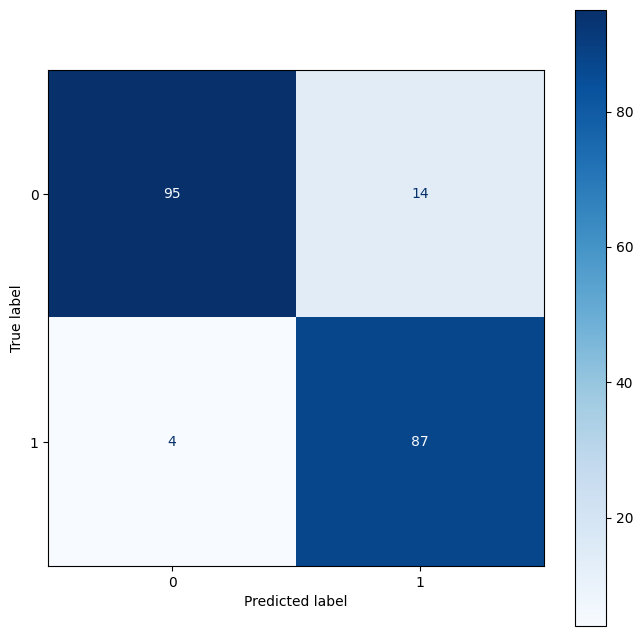

In [114]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_preds))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.grid(False)

# **Part 5 - Convolutional Neural Network Implementation**

### **Import libraries**

In [115]:
#import all datasets being used
import numpy as np # A useful package for dealing with mathematical processes, we will be using it this week for vectors and matrices.
import pandas as pd # A common package for viewing tabular data
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs
import os # we use this to oad things from the local file system
from sklearn.model_selection import train_test_split # A library that can automatically perform data splitting for us
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score # Various classification metrics we may find useful

import tensorflow as tf # loads all of tensorflow. This gives us access to everything, but we need to call the correct library
from tensorflow import keras # karas is a hgiher level library built on tensorflow. Most of what we are doing is actually using keras.
from tensorflow.keras import layers, datasets # Import the different model layers and datasets
import tensorflow_datasets as tfds # An alternate way to load tensorflow datasets
from tensorflow.keras.preprocessing.image import load_img, img_to_array # Some tensofrlow preprocessing librarie we need to load in local image files
from keras.models import Model # We'll be using the functional/graphical api for our CNNs
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

### **Unzip dataset**

In [ ]:
!unzip images_dataset2_meta.zip

### **Load metadata and images**

In [117]:
# Load metadata from the CSV file - this allows us to know what class each picture belongs to.
metadata = pd.read_csv("/content/images_dataset2_meta/metadata.csv")

# Define the directory where your images are located (in colab in our case)
image_directory = "/content/images_dataset2_meta/images"

# Define image size - this means we can rescale all our images to be the same size
image_size = (100, 100)

# Create lists to store image data and labels
images = []
labels = []

# Load and preprocess images
for index, row in metadata.iterrows():
    image_path = os.path.join(image_directory, row['Image Filename'])
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
    images.append(image_array)
    labels.append(row['Type'])

### **Dataset splitting**

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Convert string labels to numeric
label_encoder = LabelEncoder()
labels_numeric = label_encoder.fit_transform(labels)


# Shuffle and split the dataset
X_train, X_vall, y_train, y_vall = train_test_split(images, labels_numeric, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_vall, y_vall, test_size=0.5, random_state=42)

### **Convert to Numpy arrays**

In [119]:
# Convert to NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [120]:
# Data normalization
images = []
labels = []

for index, row in metadata.iterrows():
    image_path = os.path.join(image_directory, row['Image Filename'])
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array /= 255.0  # Normalize pixel values to [0, 1]
    images.append(image_array)
    labels.append(row['Type'])



### **Data augmentation**

In [121]:
# Data augmentation during training
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [122]:
# Define data generator for validation (without augmentation)
datagen_val = tf.keras.preprocessing.image.ImageDataGenerator()


In [123]:
# Fit data generator on training data
datagen_train.fit(X_train)

### **Build CNN model**

In [124]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # New convolutional layer
model.add(layers.MaxPooling2D((2, 2)))  # Additional max pooling layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # Another new convolutional layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))  # Increased number of neurons
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [125]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

In [126]:
model_improved = None

### **Compile model**

In [127]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # 'from_logits' is not needed
              metrics=['accuracy'])

### Set up callbacks

In [128]:
from tensorflow.keras.callbacks import EarlyStopping

# Create an EarlyStopping callback instance
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=2,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

### **Model training**

In [129]:
# Fit the model with the EarlyStopping callback
history = model.fit(
    X_train, y_train, epochs=10,
    validation_data=(X_val, y_val),
    batch_size=20,  # Adjust the batch size as needed
    callbacks=[early_stopping_callback]  # Add the callback here
)

Epoch 1/10
35/35 [==============================] - 14s 33ms/step - loss: 1.0655 - accuracy: 0.5857 - val_loss: 0.9117 - val_accuracy: 0.6467
Epoch 2/10
35/35 [==============================] - 0s 11ms/step - loss: 0.8209 - accuracy: 0.7300 - val_loss: 0.6140 - val_accuracy: 0.8200
Epoch 3/10
35/35 [==============================] - 0s 10ms/step - loss: 0.6100 - accuracy: 0.8243 - val_loss: 0.7919 - val_accuracy: 0.7400
Epoch 4/10
35/35 [==============================] - 0s 11ms/step - loss: 0.5341 - accuracy: 0.8429 - val_loss: 0.5684 - val_accuracy: 0.8200
Epoch 5/10
35/35 [==============================] - 0s 11ms/step - loss: 0.4381 - accuracy: 0.8700 - val_loss: 0.4997 - val_accuracy: 0.8333
Epoch 6/10
35/35 [==============================] - 0s 10ms/step - loss: 0.3733 - accuracy: 0.8714 - val_loss: 0.4618 - val_accuracy: 0.8533
Epoch 7/10
35/35 [==============================] - 0s 11ms/step - loss: 0.3159 - accuracy: 0.8971 - val_loss: 0.5138 - val_accuracy: 0.8533
Epoch 8/10
3

### **Evaluate on test set**

In [130]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=20)

# Print the test accuracy
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

8/8 [==============================] - 0s 5ms/step - loss: 0.4196 - accuracy: 0.8667
Test Accuracy: 86.67%


In [131]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)


5/5 [==============================] - 0s 28ms/step


In [132]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = y_test

In [133]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

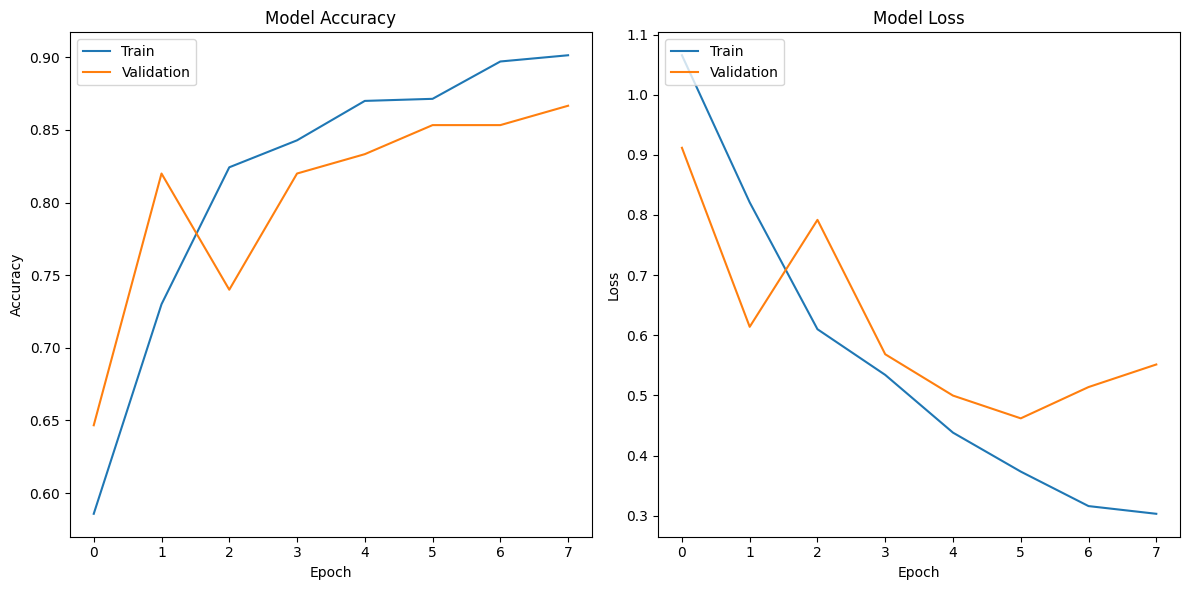

In [134]:
# Plot training and validation curves
def plot_training_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot training curves
plot_training_curves(history)

### **Chosen hyperparameters**

In [135]:
# Hyperparameters configuration
chosen_hyperparameters = {
    "rotation_range": 20,
    "width_shift_range": 0.2,
    "height_shift_range": 0.2,
    "shear_range": 0.2,
    "zoom_range": 0.2,
    "horizontal_flip": True,
    "fill_mode": "nearest",
    "conv1_filters": 32,
    "conv2_filters": 64,
    "conv3_filters": 128,
    "dense1_units": 128,
    "dense2_units": 64,
    "optimizer": "adam",
    "loss": "categorical_crossentropy"
}

In [136]:
print("Chosen Hyperparameters:")
print(chosen_hyperparameters)

Chosen Hyperparameters:
{'rotation_range': 20, 'width_shift_range': 0.2, 'height_shift_range': 0.2, 'shear_range': 0.2, 'zoom_range': 0.2, 'horizontal_flip': True, 'fill_mode': 'nearest', 'conv1_filters': 32, 'conv2_filters': 64, 'conv3_filters': 128, 'dense1_units': 128, 'dense2_units': 64, 'optimizer': 'adam', 'loss': 'categorical_crossentropy'}


### **Classification report and confusion matrix**

In [137]:
# Print classification report and confusion matrix using balanced_accuracy_score
labels_numeric = pd.get_dummies(labels)
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=labels_numeric.columns))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))
print("Balanced Accuracy:", balanced_accuracy_score(y_test_labels, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

       Large       0.00      0.00      0.00        10
    Multiple       0.77      0.92      0.84        39
        None       0.91      0.99      0.95        87
    Splinter       1.00      0.57      0.73        14

    accuracy                           0.87       150
   macro avg       0.67      0.62      0.63       150
weighted avg       0.82      0.87      0.83       150

Confusion Matrix:
[[ 0  7  3  0]
 [ 0 36  3  0]
 [ 0  1 86  0]
 [ 0  3  3  8]]
Balanced Accuracy: 0.6207528104079829


### **Evaluate against trivial baseline**

In [138]:
trivial_baseline = np.argmax(np.bincount(y_train))
y_trivial_baseline = np.full_like(y_test_labels, trivial_baseline)
print("Trivial Baseline Classification Report:")
print(classification_report(y_test_labels, y_trivial_baseline, target_names=labels_numeric.columns))

Trivial Baseline Classification Report:
              precision    recall  f1-score   support

       Large       0.00      0.00      0.00        10
    Multiple       0.00      0.00      0.00        39
        None       0.58      1.00      0.73        87
    Splinter       0.00      0.00      0.00        14

    accuracy                           0.58       150
   macro avg       0.14      0.25      0.18       150
weighted avg       0.34      0.58      0.43       150



# **Part 6 - Clustering Implementation**

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-8-fbc88f1fce96>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster_k3'] = kmeans_k3.labels_
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-8-fbc88f1fce96>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

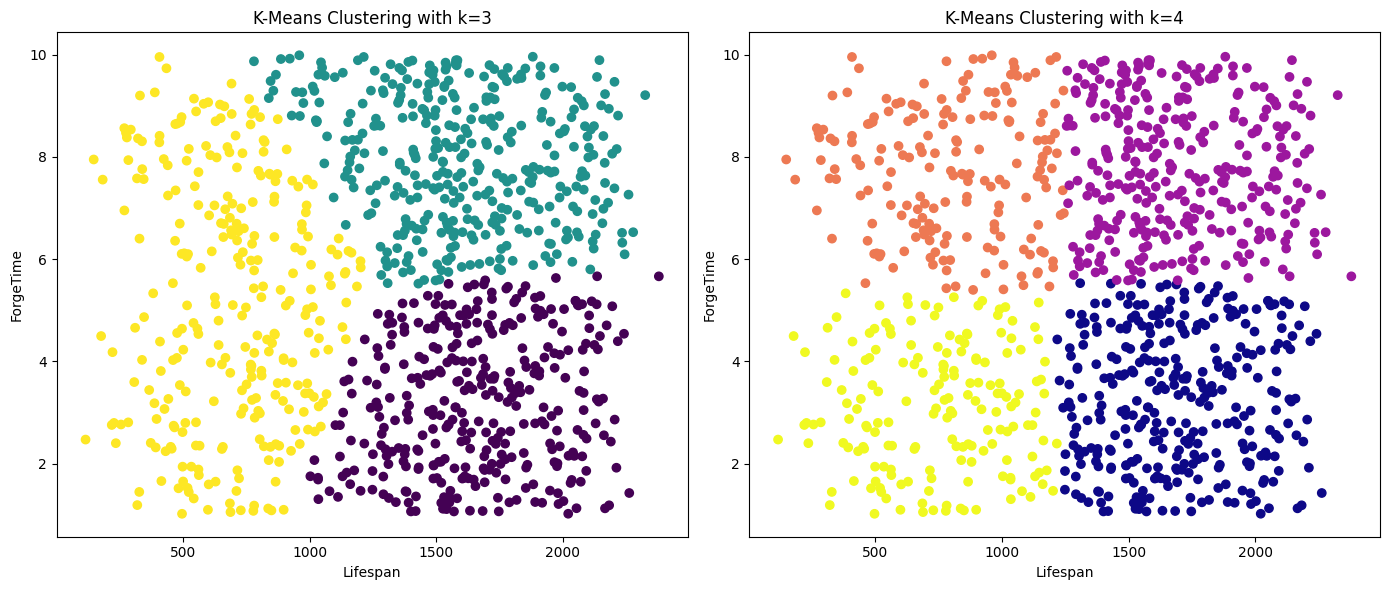

In [8]:
# Import your dataset
dataset1 = pd.read_csv("/content/dataset1.csv")
df = dataset1[['Lifespan', 'forgeTime']]

# Standardizing the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# K-means clustering for k=3
kmeans_k3 = KMeans(n_clusters=3, random_state=0).fit(df_scaled)
df['Cluster_k3'] = kmeans_k3.labels_

# K-means clustering for k=4
kmeans_k4 = KMeans(n_clusters=4, random_state=0).fit(df_scaled)
df['Cluster_k4'] = kmeans_k4.labels_

# Visualization
plt.figure(figsize=(14, 6))

# Clusters for k=3
plt.subplot(1, 2, 1)
plt.scatter(df['Lifespan'], df['forgeTime'], c=df['Cluster_k3'], cmap='viridis')
plt.title('K-Means Clustering with k=3')
plt.xlabel('Lifespan')
plt.ylabel('ForgeTime')

# Clusters for k=4
plt.subplot(1, 2, 2)
plt.scatter(df['Lifespan'], df['forgeTime'], c=df['Cluster_k4'], cmap='plasma')
plt.title('K-Means Clustering with k=4')
plt.xlabel('Lifespan')
plt.ylabel('ForgeTime')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-c5a83454a604>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster_k3'] = kmeans_k3.labels_
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-c5a83454a604>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

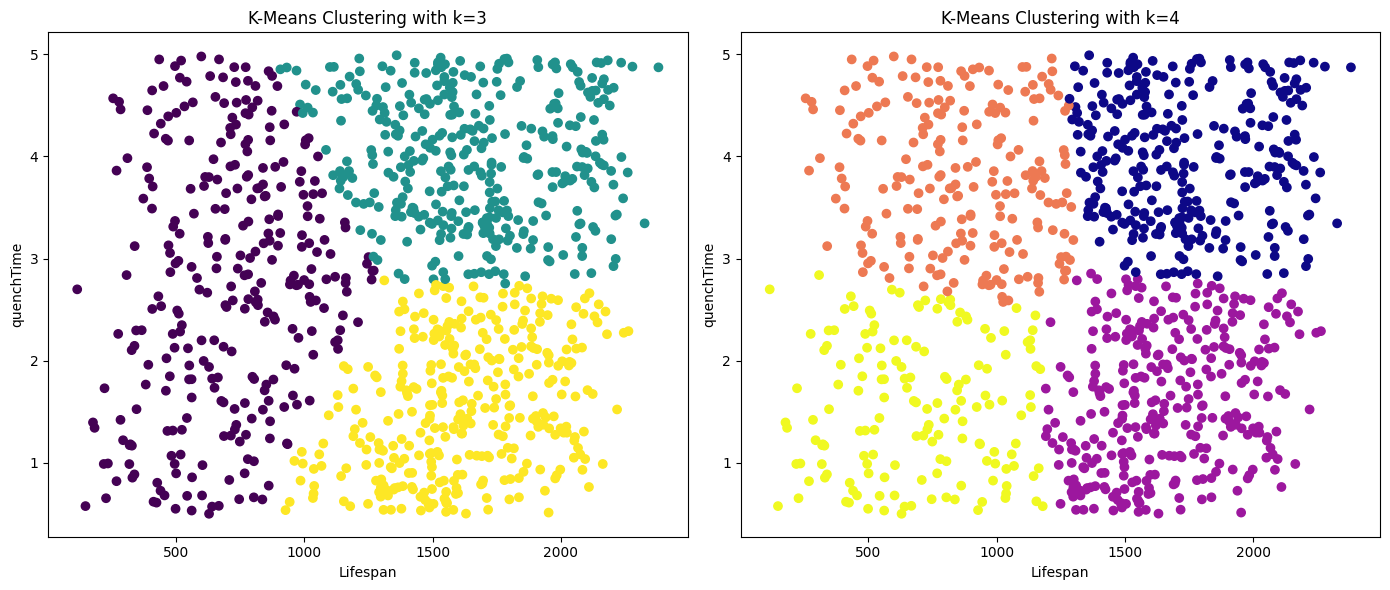

In [9]:
# Import your dataset
dataset1 = pd.read_csv("/content/dataset1.csv")
df = dataset1[['Lifespan', 'quenchTime']]

# Standardizing the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# K-means clustering for k=3
kmeans_k3 = KMeans(n_clusters=3, random_state=0).fit(df_scaled)
df['Cluster_k3'] = kmeans_k3.labels_

# K-means clustering for k=4
kmeans_k4 = KMeans(n_clusters=4, random_state=0).fit(df_scaled)
df['Cluster_k4'] = kmeans_k4.labels_

# Visualization
plt.figure(figsize=(14, 6))

# Clusters for k=3
plt.subplot(1, 2, 1)
plt.scatter(df['Lifespan'], df['quenchTime'], c=df['Cluster_k3'], cmap='viridis')
plt.title('K-Means Clustering with k=3')
plt.xlabel('Lifespan')
plt.ylabel('quenchTime')

# Clusters for k=4
plt.subplot(1, 2, 2)
plt.scatter(df['Lifespan'], df['quenchTime'], c=df['Cluster_k4'], cmap='plasma')
plt.title('K-Means Clustering with k=4')
plt.xlabel('Lifespan')
plt.ylabel('quenchTime')

plt.tight_layout()
plt.show()